In [ ]:
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.array([5, 4, 3, 2, 1])

pearson_r = np.corrcoef(x, y)  # → -1.0
pearson_r[0,1]

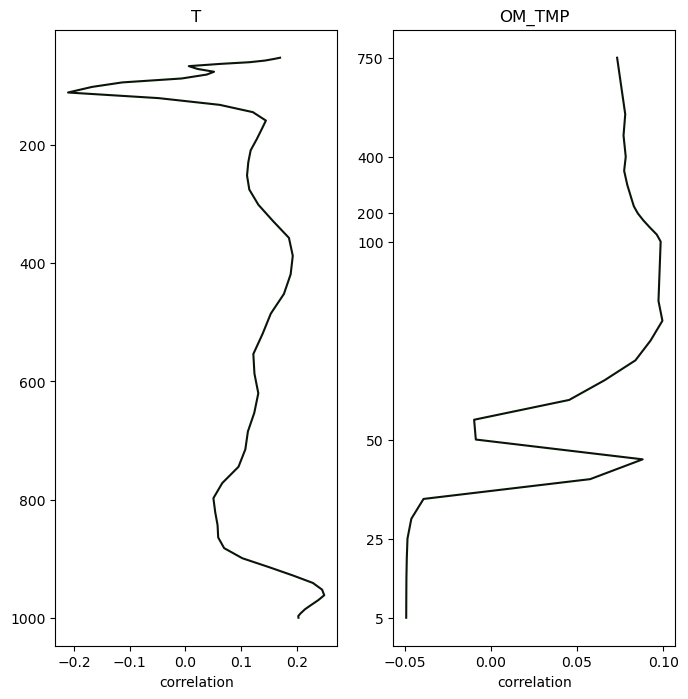

In [ ]:
import numpy as np
om_z=np.array([
     5,        10,        15,        20,        25,        30,
                                             35,        40,        45,        50,       55,       60,
                                             65,       70,       75,       80,       85,       100,
                                            125,       150,       175,       200,       225,       250,
                                            300,       350,       400,       475,       550,       750

])
eta=np.array([
    1.000, 0.997, 0.992, 0.985, 0.978, 0.969, 0.960, 0.950,
                                       0.938, 0.925, 0.910, 0.894, 0.876, 0.857, 0.835, 0.812,
                                       0.787, 0.760, 0.731, 0.700, 0.668, 0.635, 0.600, 0.565,
                                       0.530, 0.494, 0.458, 0.423, 0.388, 0.355, 0.323, 0.293,
                                       0.264, 0.237, 0.212, 0.188, 0.167, 0.147, 0.130, 0.114,
                                       0.099, 0.086, 0.074, 0.064, 0.054, 0.046, 0.039, 0.032,
                                       0.027, 0.022, 0.017, 0.013, 0.010, 0.007, 0.004, 0.002,
                                       0.000,

])
# from param import om_z,eta
from matplotlib.scale import FuncScale, register_scale
# 定义分段变换函数
def piecewise_scale(y):
    y = np.asarray(y)
    return np.where(y <= 100, y*4, (y + 1300)*2/7)  # 0-100映射到0-400，100-800映射到400-600

# 定义逆变换函数
def piecewise_inverse(y):
    y = np.asarray(y)
    return np.where(y <= 200, y/4, y*3.5 - 1300)

# 注册自定义比例尺
class PiecewiseScale(FuncScale):
    name = 'piecewise'
    def __init__(self, axis):
        FuncScale.__init__(self, axis, functions=(piecewise_scale, piecewise_inverse))

register_scale(PiecewiseScale)
import os
pwd="/share/home/lililei1/kcfu/tc_mangkhut/plot_scripts"
os.chdir(pwd)
import sys

import netCDF4 as nc
import wrf
from kc_functions import nc_read1
import pandas as pd
import subprocess
import matplotlib.pyplot as plt

if __name__ == "__main__":
    #==================================================
    #basic settings
    work_dir="/share/home/lililei1/kcfu/tc_mangkhut"
    obs_dir=f"{work_dir}/3create_obs/hx_rttov/3obs_BT"
    ensmem_dir=f"{work_dir}/2ens_free_fcst"
    ens_hx_dir=f'{work_dir}/3create_obs/hx_rttov/4ens_BT'

    domain='d01'
    day_list=['10']
    hour_list=['00']
    minute='00'
    itime=0
    wrf_time=day_list[itime]+'_'+hour_list[itime]+':'+minute#10_00:00
    time=day_list[itime]+'_'+hour_list[itime]+'_'+minute#10_00_00
    mem_list=[51,70, 54,48 ,47 ,69 ,20, 71,
              24, 25 ,39 ,31 ,38 ,73 ,49 ,41 ,62,
              1,2,3,4,5,6,7]
    varname_list=['T','OM_TMP']
    chnum='1'
    nobs=676
    nAllMenObs=nobs*len(mem_list)
    instrument='AMSUA'
    read_cache=True
    #==================================================
    #configure of wrfout
    nAtmos_level=56
    nOcean_level=30

    #PLEASE just fill the j and i_start with the RAW number in namelist.input
    i_parent_start=27
    j_parent_start=88

    d02_start_dd='09'
    d02_start_hh='06'
    time_index=int(((int(day_list[itime])-int(d02_start_dd))*24
                +int(hour_list[itime])-int(d02_start_hh))/3)
    
    NR_jlist=np.loadtxt(f'{work_dir}/0necessay_files/NR_d02_jlist.txt')
    NR_ilist=np.loadtxt(f'{work_dir}/0necessay_files/NR_d02_ilist.txt')
    #calc the TC center index in d01(domain)
    jCenter_index=round(NR_jlist[time_index]/5)+j_parent_start
    iCenter_index=round(NR_ilist[time_index]/5)+i_parent_start
    #==================================================
    #read hx file
    obs_file=f'{obs_dir}/{instrument}/BT_{time}/obs_{domain}_ch{chnum}_totalline_withpert.txt'
    obs=np.loadtxt(obs_file)
    #==================================================
    #read ensmem vars and calc corr
    if read_cache:
        dfs=[]
        for ivar,varname in enumerate(varname_list):
            corr=pd.read_csv(f'{pwd}/corr_cache/mean_ch{chnum}_corr_{varname}.csv')
            dfs.append(corr)
    else:
        length_of_obs=np.sqrt(nobs)#the length of the area where obs locates
        radius=int(length_of_obs/2)
        ens_Jslice=slice(jCenter_index-radius+1,jCenter_index+radius+1)
        ens_Islice=slice(iCenter_index-radius+1,iCenter_index+radius+1)
        obs_list=np.arange(nobs).tolist()
        dfs=[]
        for ivar,varname in enumerate(varname_list):
            wrfout_ens=[]
            ens_hx=[]
            for imem,member in enumerate(mem_list):
                member="mem{:03d}".format(member)
                member_dir=f"{ensmem_dir}/{member}"
                hx=np.loadtxt(f'{ens_hx_dir}/{member}/{instrument}/BT_{time}/obs_{domain}_ch{chnum}_totalline.txt')
                wrf_name=f'{member_dir}/wrfout_{domain}_2018-09-{wrf_time}:00'
                wrf_var=wrf.to_np(nc_read1(wrf_name,varname)[:,ens_Jslice,ens_Islice])
                wrfout_ens.append(wrf_var)
                ens_hx.append(hx) 
            #-----------------------
            #judge if the var is Oceanic(OM) or not
            if varname[:2] == 'OM':
                zlevel=nOcean_level
            else:
                zlevel=nAtmos_level
            level_list=np.arange(zlevel).tolist()
            corr_record=pd.DataFrame(np.nan,index=level_list,columns=obs_list)
            #---------------------
            #each obs point,calc corr
            for iobs in obs_list:
                
                for nlevel in range(zlevel):
                    var_mem_list=[]
                    ens_hx_list=[]
                    for imem,member in enumerate(mem_list):
                        wrf_var2=wrfout_ens[imem]
                        wrf_var_level=np.reshape(wrf_var2[nlevel],nobs*1,order='F')
                        #append list
                        var_mem_list.append(wrf_var_level[iobs])
                        ens_hx_list.append(ens_hx[imem][iobs])

                    corr=np.corrcoef(var_mem_list,ens_hx_list)[0,1]
                    corr_record.loc[nlevel,iobs]=corr
            subprocess.run(['mkdir','-p',f'{pwd}/corr_cache'])
            #calc mean npoints corr at each level
            corr_mean=corr_record.mean(axis=1)
            corr_mean.to_csv(f'{pwd}/corr_cache/mean_ch{chnum}_corr_{varname}.csv')
            dfs.append(corr_mean)
        # df_mean=sum(dfs)/len(dfs)
        # df_mean.to_csv(f'{pwd}/corr_cache/corr_mean.csv')
    #===================================================
    #plot
    #v1 temporate version
    p_bot=1000.
    p_top=50.

    p=eta*(p_bot-p_top)+p_top
    fig,axs=plt.subplots(1,len(varname_list), figsize=(8,4*len(varname_list)))
    kc_blue="#091508"
    for ivar,varname in enumerate(varname_list):
        ax=axs[ivar]
        if read_cache:
            df=pd.DataFrame(dfs[ivar])
            corr=df.iloc[:,1]
        else:
            corr=dfs[ivar]
        if varname[:2] != 'OM':
            ax.plot(corr,p[:-1],linestyle='-',color=kc_blue)
            ax.set_title(varname)
            ax.set_xlabel('correlation')
            ax.invert_yaxis()
        else:  
            ax.plot(corr,om_z,color=kc_blue)
            
            ax.set_title(varname)
            ax.set_xlabel('correlation')
            ax.set_yscale('piecewise')
            ax.set_yticks([5, 25, 50, 100, 200, 400, 750])
            ax.set_yticklabels(['5', '25', '50','100', '200', '400', '750'])


In [ ]:
from param import om_z,eta
from matplotlib.scale import FuncScale, register_scale
# 定义分段变换函数
def piecewise_scale(y):
    y = np.asarray(y)
    return np.where(y <= 100, y*4, (y + 1300)*2/7)  # 0-100映射到0-400，100-800映射到400-600

# 定义逆变换函数
def piecewise_inverse(y):
    y = np.asarray(y)
    return np.where(y <= 200, y/4, y*3.5 - 1300)

# 注册自定义比例尺
class PiecewiseScale(FuncScale):
    name = 'piecewise'
    def __init__(self, axis):
        FuncScale.__init__(self, axis, functions=(piecewise_scale, piecewise_inverse))

register_scale(PiecewiseScale)
p_bot=1000.
p_top=50.

p=eta*(p_bot-p_top)+p_top
fig,axs=plt.subplots(1,len(varname_list), figsize=(8,4*len(varname_list)))
kc_blue="#091508"
for ivar,varname in enumerate(varname_list):
    ax=axs[ivar]
    corr=dfs[ivar].iloc[:,1]
    if varname[:2] != 'OM':
        ax.plot(corr,p[:-1],linestyle='-',color=kc_blue)
        ax.set_title(varname)
        ax.set_xlabel('correlation')
        ax.invert_yaxis()
    else:  
        ax.plot(corr,om_z,color=kc_blue)
        
        ax.set_title(varname)
        ax.set_xlabel('correlation')
        ax.set_yscale('piecewise')
        ax.set_yticks([5, 25, 50, 100, 200, 400, 750])
        ax.set_yticklabels(['5', '25', '50','100', '200', '400', '750'])

In [27]:
import netCDF4 as nc
def nc_read1(filename,var):
    with nc.Dataset(filename,'r') as ncfile:
        data = ncfile.variables[var][:].squeeze()
        return data
    
domain='d01'
work_dir="/share/home/lililei1/kcfu/tc_mangkhut"
obs_dir=f"{work_dir}/3create_obs/hx_rttov/3obs_BT"
ensmem_dir=f"{work_dir}/2ens_free_fcst"

length_of_obs=np.sqrt(nobs)#the length of the area where obs locates
radius=int(length_of_obs/2)
ens_Jslice=slice(jCenter_index-radius+1,jCenter_index+radius+1)
ens_Islice=slice(iCenter_index-radius+1,iCenter_index+radius+1)

mem_list=[51,70, 54,48 ,47 ,69 ,20, 71,
              24, 25 ,39 ,31 ,38 ,73 ,49 ,41 ,62,
              1,2,3,4,5,6,7]

level_select=0
wrf_var_list=[]
T_select=[]
varname='OM_TMP'
nz=30
for imem,member in enumerate(mem_list):
    member="mem{:03d}".format(member)
    member_dir=f"{ensmem_dir}/{member}"
    wrf_name=f'{member_dir}/wrfout_{domain}_2018-09-{wrf_time}:00'
    wrf_var=wrf.to_np(nc_read1(wrf_name,varname)[:,ens_Jslice,ens_Islice])
    T=wrf.to_np(nc_read1(wrf_name,'T')[level_select,ens_Jslice,ens_Islice])
    T_select.append(T)
    wrf_var_list.append(wrf_var)

corr_list=[]
for ilevel in range(nz):
    corr_level=[]
    for iobs in range(nobs):
        T_list=[]
        var_list=[]
        for imem,member in enumerate(mem_list):
            T_iobs=np.reshape(T_select[imem],nobs)[iobs]
            T_list.append(T_iobs)

            var_iobs=np.reshape(wrf_var_list[imem][ilevel],nobs)[iobs]
            var_list.append(var_iobs)
        corr=np.corrcoef(var_list,T_list)[0,1]

        corr_level.append(corr)
    corr_mean=np.mean(corr_level)
    corr_list.append(corr_mean)





In [2]:
import numpy as np
a1=np.array(
    [1,2,5,8,9]
)
a2=np.array(
    [0,5,2,7,3]
)
np.corrcoef(a1,a2)


array([[1.        , 0.47108153],
       [0.47108153, 1.        ]])